In [2]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist, obs_coronagraphy
from pynrc.obs_nircam import plot_contrasts, planet_mags, plot_planet_patches

from pynrc.speckle_noise import offset_bar
pynrc.setup_logging('WARNING', verbose=False)

from astropy.io import (fits, ascii)

# Observation Definitions

Functions to create and optimize a series of observation objects stored as a dictionary.

In [4]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [5]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None, args_disk=None, 
            subsize=None, wind_mode=None, fov_pix=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 320 pixels. 
    For the case of SW+MASK335R, we also assume that the subarray size matches 
    that of a simultaneous LW observation (320x320).
    """
    
    if sp_ref is None: sp_ref = sp_sci

    obs_dict = {}
    for filt, mask, pupil in filt_list:
        # Create identification key
        key = make_key(filt, mask=mask, pupil=pupil)
        if verbose: print(key)

        # Disk Model
        if args_disk is None:
            hdu_disk = None
        else:
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)

        if wind_mode is None:
            wind_mode = 'WINDOW'
            
        # Define the subarray readout size
        if subsize is None:
            if mask is None: # Direct Imaging
                subsize = 400
            elif ('210R' in mask) or ('SWB' in mask): # SW Coronagraphy
                subsize = 640
            else: # LW Coronagraphy
                subsize = 320
        if 'FULL' in wind_mode:
            subsize=2048
                
        # Define PSF pixel size
        fov_pix_orig = fov_pix
        fov_pix = subsize if fov_pix is None else fov_pix
        # Make sure fov_pix is odd for direct imaging
        if (mask is None) and (np.mod(fov_pix,2)==0):
            fov_pix += 1

        # Other coronagraph vs direct imaging settings
        module, oversample = ('B', 4) if mask is None else ('A', 2)
        
        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_hci(sp_sci, sp_ref, dist, filter=filt, mask=mask, pupil=pupil, 
                                      wfe_ref_drift=wfe_drift, fov_pix=fov_pix, oversample=oversample, 
                                      wind_mode=wind_mode, xpix=subsize, ypix=subsize,
                                      disk_hdu=hdu_disk, verbose=verbose)
        fov_pix = fov_pix_orig
        
    return obs_dict

# Sources and Bandpasses

Define Sources and their Reference Counterparts

In [6]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [7]:
# Science         source,  dist,  age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('Vega',    7.7,  450,  'A0V', 9602, -0.50, 4.10, 0.13, bp_k)]

# References     source, sptype, Teff, [Fe/H], log_g, mag, band
ref_sources = [('Deneb',  'A2I', 8525, -0.25, 2.00, 0.88, bp_k)]

In [8]:
# List of filters
args_filter = [('F356W', 'MASK430R', 'CIRCLYOT'),
               ('F444W', 'MASK430R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

# Vega

In [96]:
# Fit spectrum to SED photometry

i=0
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[i]
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]

# Source spectrum
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
sp_sci = pynrc.stellar_spectrum(spt_sci, mag_sci, 'vegamag', bp_sci, **kwargs)
sp_sci.name = name_sci

kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
sp_ref = pynrc.stellar_spectrum(spt_ref, mag_ref, 'vegamag', bp_ref, **kwargs)
sp_ref.name = name_ref

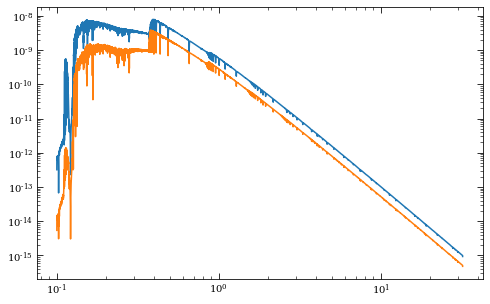

In [97]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.loglog(sp_sci.wave/1e4, sp_sci.flux)
ax.loglog(sp_ref.wave/1e4, sp_ref.flux)

In [98]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='FULL', fov_pix=1024, verbose=True)

F356W_MASK430R_CIRCLYOT
Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.
F444W_MASK430R_CIRCLYOT
Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.


In [99]:
obs1 = obs_dict[filt_keys[0]] # F356W
obs2 = obs_dict[filt_keys[1]] # F444W

### Readout Patterns

In [12]:
# Optimize F356W

# Spectrum to optimize (some very faint flat guy)
sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)

# Vega/Denev are going to be the brightest sources, limited by saturaiton level
# Because of strong saturation, ignore those patterns with coadding (only RAPID and BRIGHT1)
# Look at both science and reference source since they need to be same readout
kwargs = {'patterns':['RAPID','BRIGHT1'], 'tacq_max': 600, 'well_frac_max': 50, 'nint_min': 5}
for sp in [sp_sci, sp_ref]:
    _ = obs1.ramp_optimize(sp_opt, sp, verbose=True, **kwargs)
    print('')

BRIGHT1
RAPID
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID         8    5     85.89    429.47    483.16     36.7   45.323    1.670
RAPID         8    6     85.89    515.36    579.79     40.2   45.323    1.670
RAPID         8    7     85.89    601.26    676.42     43.4   45.323    1.670
BRIGHT1       4    6     75.16    450.94    515.37     30.5   39.657    1.342
BRIGHT1       4    7     75.16    526.10    601.26     32.9   39.657    1.342
BRIGHT1       4    8     75.16    601.26    687.16     35.2   39.657    1.342

BRIGHT1
RAPID
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10    5    107.37    536.84    590.53     47.4   28.810    1.951
RAPID        10    6    107.37    644.21    708.63     51.9   28.810    1.951
BRIGHT1       6    5    118.10    5

In [13]:
# Optimize F444W
kwargs = {'patterns':['RAPID','BRIGHT1'], 'tacq_max': 1000, 'well_frac_max': 50, 'nint_min': 5}
for sp in [sp_sci, sp_ref]:
    _ = obs2.ramp_optimize(sp_opt, sp, verbose=True, **kwargs)
    print('')

BRIGHT1
RAPID
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
BRIGHT1      10    5    204.00   1019.99   1073.68     77.5   43.110    2.366
BRIGHT1       9    5    182.53    912.63    966.31     70.4   38.572    2.266
BRIGHT1       8    5    161.05    805.26    858.95     62.9   34.034    2.145
BRIGHT1       7    5    139.58    697.89    751.58     54.8   29.496    1.999
RAPID        10    7    107.37    751.57    826.74     55.4   22.689    1.927
RAPID        10    8    107.37    858.94    944.84     59.2   22.689    1.927
RAPID        10    9    107.37    966.31   1062.95     62.8   22.689    1.927

BRIGHT1
RAPID
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
BRIGHT1      10    5    204.00   1019.99   1073.68     77.5   22.057    2.366
BRIGHT1       9    5    182.53    9

In [100]:
# Update exposure times (per roll)
obs1.update_detectors(read_mode='RAPID', ngroup=9, nint=5)
obs1.nrc_ref.update_detectors(read_mode='RAPID', ngroup=9, nint=5)

obs2.update_detectors(read_mode='BRIGHT1', ngroup=9, nint=5)
obs2.nrc_ref.update_detectors(read_mode='BRIGHT1', ngroup=9, nint=5)

### Saturation Levels

In [17]:
# Max Saturation values and locations (80% at 2 groups)
for key in filt_keys:
    print(key)
    obs = obs_dict[key]
    
    ng = 2
    im_sat1 = obs.saturation_levels(ngroup=ng, do_ref=False)
    im_sat2 = obs.saturation_levels(ngroup=ng, do_ref=True)
    rho = nrc_utils.dist_image(im_sat1)  # Pixel distances
    dmax1 = np.max(rho[im_sat1==im_sat1.max()]) * obs.pix_scale
    dmax2 = np.max(rho[im_sat2==im_sat2.max()]) * obs.pix_scale

    print('Max sci saturation of {:.1f} well at {:.1f} arcsec'.format(im_sat1.max(), dmax1))
    print('Max ref saturation of {:.1f} well at {:.1f} arcsec'.format(im_sat2.max(), dmax2))

    
    # How many saturated values can we easily fix?
    for sat_level in [im_sat1, im_sat2]:
        sat_mask = sat_level > 0.8
        nsat0 = np.size(rho[sat_mask])
        sat_level[sat_mask] = np.nan
        sat_level = nrc_utils.fix_nans_with_med(sat_level, niter_max=2)

        # Set any NaNs to 1.0
        nan_mask = np.isnan(sat_level)
        sat_level[nan_mask] = 1
        sat_mask = sat_level > 0.8
    
        # Get final info about saturation levels
        nsat = np.size(rho[sat_mask])
        rval = rho[sat_mask].max()*obs.pix_scale if nsat>0 else 0
        print('nsat = ({}, {}); rmax = {:.2f} arcsec'.format(nsat0, nsat, rval))
        
    print('')


F356W_MASK430R_CIRCLYOT
Max sci saturation of 11.3 well at 0.4 arcsec
Max ref saturation of 5.8 well at 0.4 arcsec
nsat = (1203, 121); rmax = 1.28 arcsec
nsat = (584, 3); rmax = 1.14 arcsec

F444W_MASK430R_CIRCLYOT
Max sci saturation of 6.8 well at 0.5 arcsec
Max ref saturation of 3.5 well at 0.5 arcsec
nsat = (1126, 43); rmax = 1.48 arcsec
nsat = (453, 0); rmax = 0.00 arcsec



### F356W Images/Curves

In [124]:
obs = obs1

In [125]:
# Cycle through a few WFE drift values
wfe_list = [0,2,5,10]

# PA values for each roll
PA1, PA2 = (200, 210)

# PA values for each roll
roll_angle = np.abs(PA2-PA1)

# A dictionary of HDULists
hdul_dict = {}
curves = []
for wfe_drift in wfe_list:
    print(wfe_drift)
    # Upate WFE reference drift value
    obs.wfe_ref_drift = wfe_drift
            
    # Set the final output image to be oversampled
    hdulist = obs.gen_roll_image(PA1=PA1, PA2=PA2, oversample=1)

    # Generate contrast curves
    rr, contrast, sen_mag = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, hdu_diff=hdulist)

    # Mask r<1.5"
    data = hdulist[0].data
    rho = nrc_utils.dist_image(data, pixscale=hdulist[0].header['PIXELSCL'])
    data[rho<1.5] = 0
    hdul_dict[wfe_drift] = hdulist
    
    # Only keep rr>1.5"
    ind = rr>1.5
    result = (rr[ind], contrast[ind], sen_mag[ind])
    curves.append(result)

0
2
5
10


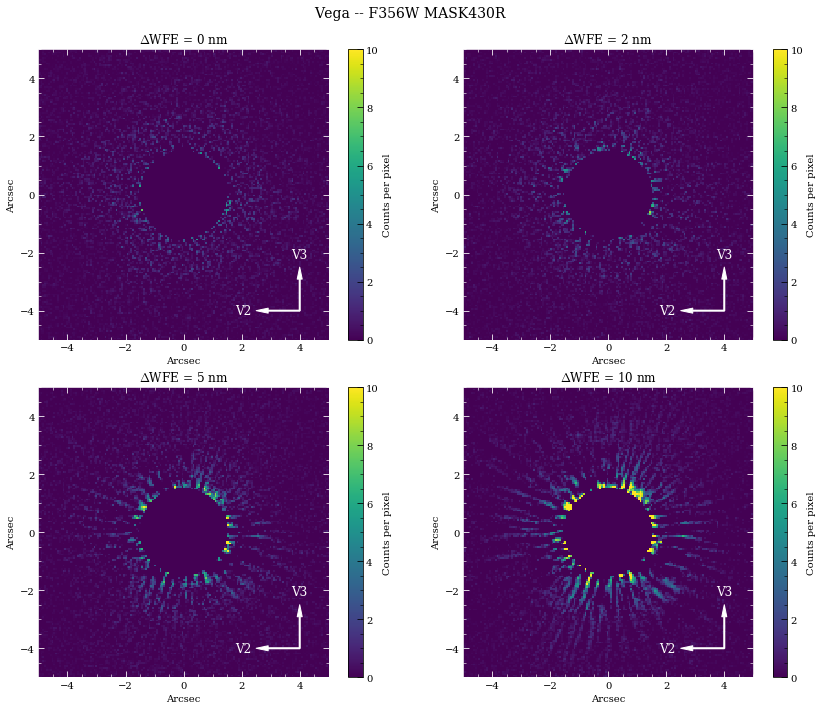

In [53]:
from pynrc.obs_nircam import plot_hdulist
from matplotlib.patches import Circle

fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
xylim = 5

for j, wfe_drift in enumerate(wfe_list):
    ax = axes[j]
    hdul = hdul_dict[wfe_drift]
    
    xyr = [-xylim, xylim]
    plot_hdulist(hdul, xr=xyr, yr=xyr, ax=ax, vmin=0, vmax=10)

    ax.set_title('$\Delta$WFE = {:.0f} nm'.format(wfe_drift))
    
    nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15)


fig.suptitle('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.92)

fig_name = '{}_{}_{}_images.pdf'.format(name_sci, obs.filter, obs.mask)
fig.savefig('Exoplanets/'+fig_name)

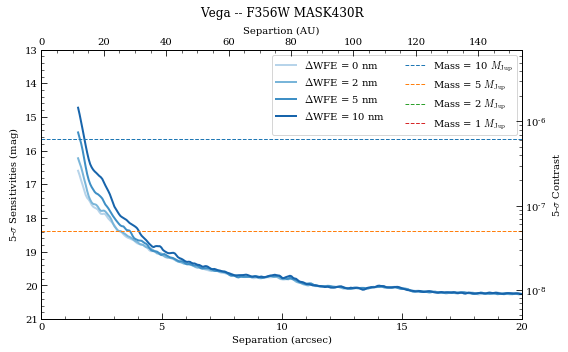

In [128]:
from pynrc.obs_nircam import plot_contrasts, plot_planet_patches

fig, ax = plt.subplots(figsize=(8,5))
xr=[0,20]
yr=[21,13]

# Plot contrast curves and set x/y limits
ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, 
                              xr=xr, yr=yr, ax=ax, return_axes=True)

# Plot Spiegel & Burrows (2012) exoplanet fluxes (Hot Start)
plot_planet_patches(ax, obs, age=age, entropy=13, av_vals=None)
#ax.set_title(ax.get_title(), y=1.1)

ax.legend(ncol=2)

ax.set_title('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), y=1.1)

fig.tight_layout()

fig_name = '{}_{}_{}_contrast.pdf'.format(name_sci, obs.filter, obs.mask)
fig.savefig('Exoplanets/'+fig_name)
#fig.subplots_adjust(top=0.6)

In [126]:
from astropy.table import Table


# Save curves data
data = []
names =[]

rr = curves[0][0]
data.append(rr)
names.append('Arcsec')

for j, vals in enumerate(curves):
    rr, contrast, sen = vals
    
    data.append(contrast)
    data.append(sen)
    
    wfe = wfe_list[j]
    names.append('Contr_{:.0f}nm'.format(wfe))
    names.append('Sen_{:.0f}nm'.format(wfe))
    
# Modify number formats
tbl = Table(data, names=names)
tbl[names[0]].format = '.4f'
for name in names:
    if  'Cont' in name: fmt = '.3E'
    elif 'Sen' in name: fmt ='.4f'
    else: fmt = tbl[name].format
        
    tbl[name].format = fmt

In [127]:
# Save data
fname = '{}_{}_{}_curves'.format(name_sci, obs.filter, obs.mask)
ascii.write(tbl, 'Exoplanets/'+fname+'.dat')  
ascii.write(tbl, 'Exoplanets/'+fname+'.csv', format='csv')  

### F444W Images/Curves

In [55]:
obs = obs2

In [57]:
# Cycle through a few WFE drift values
wfe_list = [0,2,5,10]

# PA values for each roll
PA1, PA2 = (200, 210)

# PA values for each roll
roll_angle = np.abs(PA2-PA1)

# A dictionary of HDULists
hdul_dict = {}
curves = []
for wfe_drift in wfe_list:
    print(wfe_drift)
    # Upate WFE reference drift value
    obs.wfe_ref_drift = wfe_drift
            
    # Set the final output image to be oversampled
    hdulist = obs.gen_roll_image(PA1=PA1, PA2=PA2, oversample=1)

    # Generate contrast curves
    rr, contrast, sen_mag = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, hdu_diff=hdulist)

    # Mask r<1.5"
    data = hdulist[0].data
    rho = nrc_utils.dist_image(data, pixscale=hdulist[0].header['PIXELSCL'])
    data[rho<1.5] = 0
    hdul_dict[wfe_drift] = hdulist
    
    # Only keep rr>1.5"
    ind = rr>1.5
    result = (rr[ind], contrast[ind], sen_mag[ind])
    curves.append(result)

0
2
5
10


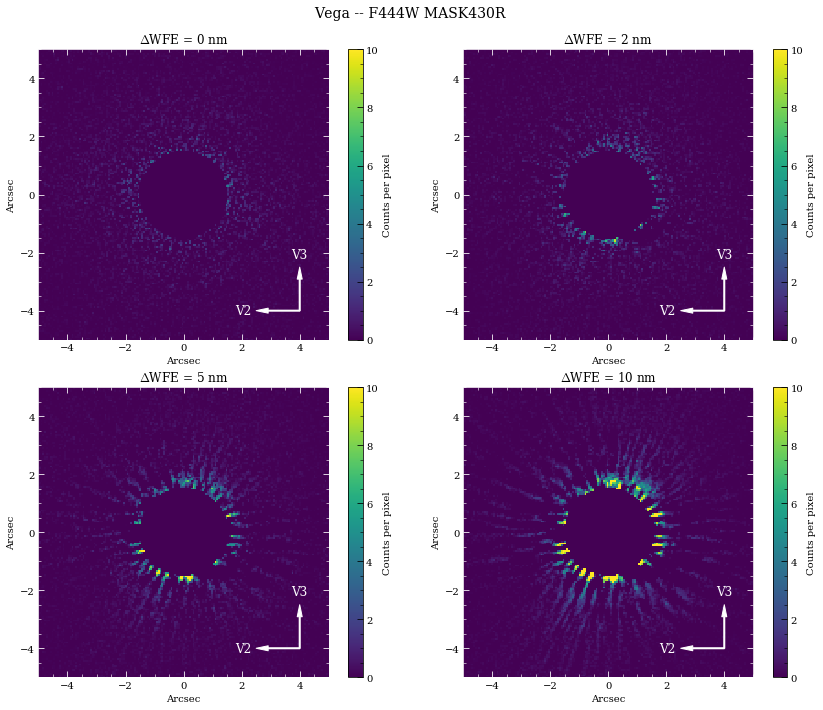

In [58]:
from pynrc.obs_nircam import plot_hdulist
from matplotlib.patches import Circle

fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
xylim = 5

for j, wfe_drift in enumerate(wfe_list):
    ax = axes[j]
    hdul = hdul_dict[wfe_drift]
    
    xyr = [-xylim, xylim]
    plot_hdulist(hdul, xr=xyr, yr=xyr, ax=ax, vmin=0, vmax=10)

    ax.set_title('$\Delta$WFE = {:.0f} nm'.format(wfe_drift))
    
    nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15)


fig.suptitle('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.92)

fig_name = '{}_{}_{}_images.pdf'.format(name_sci, obs.filter, obs.mask)
fig.savefig('Exoplanets/'+fig_name)

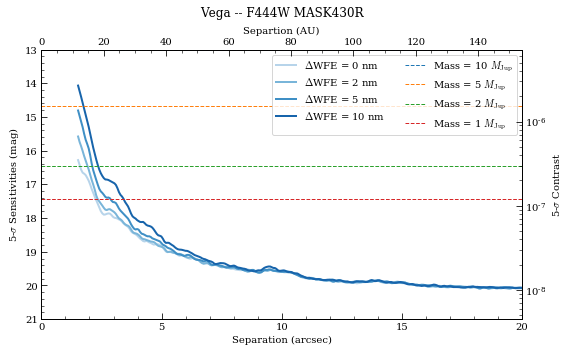

In [63]:
from pynrc.obs_nircam import plot_contrasts, plot_planet_patches

fig, ax = plt.subplots(figsize=(8,5))
xr=[0,20]
yr=[21,13]

# Plot contrast curves and set x/y limits
ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, 
                              xr=xr, yr=yr, ax=ax, return_axes=True)

# Plot Spiegel & Burrows (2012) exoplanet fluxes (Hot Start)
plot_planet_patches(ax, obs, age=age, entropy=13, av_vals=None)
#ax.set_title(ax.get_title(), y=1.1)

ax.legend(ncol=2)

ax.set_title('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), y=1.1)

fig.tight_layout()

fig_name = '{}_{}_{}_contrast.pdf'.format(name_sci, obs.filter, obs.mask)
fig.savefig('Exoplanets/'+fig_name)
#fig.subplots_adjust(top=0.6)

In [ ]:
from astropy.table import Table


# Save curves data
data = []
names =[]

rr = curves[0][0]
data.append(rr)
names.append('Arcsec')

for j, vals in enumerate(curves):
    rr, contrast, sen = vals
    
    data.append(contrast)
    data.append(sen)
    
    wfe = wfe_list[j]
    names.append('Contr_{:.0f}nm'.format(wfe))
    names.append('Sen_{:.0f}nm'.format(wfe))
    
# Modify number formats
tbl = Table(data, names=names)
tbl[names[0]].format = '.4f'
for name in names:
    if  'Cont' in name: fmt = '.3E'
    elif 'Sen' in name: fmt ='.4f'
    else: fmt = tbl[name].format
        
    tbl[name].format = fmt

In [ ]:
# Save data
fname = '{}_{}_{}_curves'.format(name_sci, obs.filter, obs.mask)
ascii.write(tbl, 'Exoplanets/'+fname+'.dat')  
ascii.write(tbl, 'Exoplanets/'+fname+'.csv', format='csv')  

## Full observation simulations

The goal here is to first make a realistic slope image as seen at the detector focal plane. This slope images will then be passed to the `gen_exposures` function to create a MULTIACCUM sampled image cube.

In [101]:
for k in filt_keys:
    obs = obs_dict[k]
    obs.wfe_roll_drift = 0
    obs.wfe_ref_drift = 5

In [144]:
# Select F444W with two rolls at PA of 70 and 80 degrees
obs = obs2

# PA values for each roll
PA1, PA2 = (200, 210)
roll_angle = np.abs(PA2-PA1)

# Detector ID
det = obs.Detectors[0]
detid = det.detid

# Detector size
xpix, ypix = (obs.det_info['xpix'], obs.det_info['ypix'])

# Dictionary of mask location info
cdict = nrc_utils.coron_ap_locs(obs.module, obs.channel, obs.mask, full=True)

# Location of mask in V2/V3 coords
xc, yc = cdict['cen_V23']
# Amount to shift (only need for full array observations)
delx = xc - xpix/2
dely = yc - ypix/2

In [145]:
# Add a random planet
rtheta = (10, 45.0) # 10 arcsec radius at PA=45
obs.kill_planets()
obs.add_planet(mass=1, age=age, entropy=8, rtheta=rtheta, runits='arcsec')

In [146]:
# Make zodiacal background image
from astropy.convolution import convolve_fft
from scipy import fftpack

# Take
cmask = obs.mask_images['A5']
im_zodi = cmask * obs.bg_zodi()

# Convolve with PSF (coronagraphic mask sits behind Lyot stop)
fov_pix = obs.psf_info['fov_pix']
psf = nrc_utils.krebin(obs.psf_offaxis_over, (fov_pix,fov_pix))
psf /= psf.sum()
im_zodi = convolve_fft(im_zodi, psf, fftn=fftpack.fftn, ifftn=fftpack.ifftn, allow_huge=True)

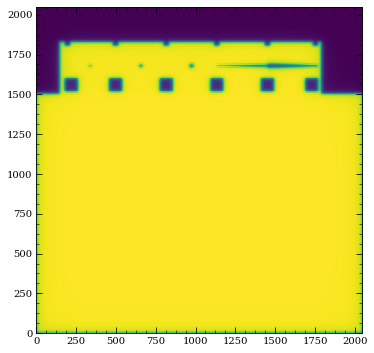

In [147]:
plt.imshow(im_zodi)

In [148]:
# Disk Images
im_disk1 = obs.gen_disk_image(PA_offset=PA1, use_cmask=True)
im_disk2 = obs.gen_disk_image(PA_offset=PA2, use_cmask=True)

if isinstance(im_disk1, np.ndarray):
    # Shift to MASK430R spot
    im_disk1 = nrc_utils.fshift(im_disk1, delx, dely, pad=True)
    im_disk2 = nrc_utils.fshift(im_disk2, delx, dely, pad=True)

In [149]:
# Planet Images
im_pl1 = obs.gen_planets_image(PA_offset=PA1, use_cmask=False)
im_pl2 = obs.gen_planets_image(PA_offset=PA2, use_cmask=False)

if isinstance(im_pl1, np.ndarray):
    # Shift to MASK430R spot
    im_pl1 = nrc_utils.fshift(im_pl1, delx, dely, pad=True)
    im_pl2 = nrc_utils.fshift(im_pl2, delx, dely, pad=True)

In [150]:
# Create stellar images
im_star = obs.gen_psf(sp_sci)
im_ref  = obs.nrc_ref.gen_psf(sp_ref)

im_star = nrc_utils.pad_or_cut_to_size(im_star, (ypix,xpix))
im_ref  = nrc_utils.pad_or_cut_to_size(im_ref, (ypix,xpix))

# Shift to MASK430R spot
im_star = nrc_utils.fshift(im_star, delx, dely, pad=True)
im_ref  = nrc_utils.fshift(im_ref,  delx, dely, pad=True)

In [151]:
sci_slope1 = im_star + im_disk1 + im_pl1 + im_zodi
sci_slope2 = im_star + im_disk2 + im_pl2 + im_zodi

ref_slope  = im_ref + im_zodi

In [152]:
# Everything has been in V2/V3 coords
# Convert to detector coordiantes
sci_slope1 = nrc_utils.V2V3_to_det(sci_slope1, detid)
sci_slope2 = nrc_utils.V2V3_to_det(sci_slope2, detid)
ref_slope = nrc_utils.V2V3_to_det(ref_slope, detid)

In [153]:
# Superbias for data reduction
caldir  = pynrc.conf.PYNRC_PATH + 'sca_images/'
fbias = caldir + 'SUPER_BIAS_485.FITS'
hdl = fits.open(fbias)
bias = hdl[0].data

In [154]:
def average_slopes(ramps, bias):
    """
    For a series of ramps, calculate the slope images then average together.
    Would it be better to average integrations into one ramp, then find slope???
    """

    slopes_fin = []
    for i in range(len(ramps)):
        #print(i)
        hdulist = ramps[i]
        data = hdulist[1].data
        header = hdulist[0].header
        ref_obj = pynrc.ref_pixels.NRC_refs(data, header, DMS=True)
        ref_obj.calc_avg_amps()
        ref_obj.correct_amp_refs()

        # Subtract superbias
        data_corr = ref_obj.data
        for im in data_corr:
            im -= bias

        # Create time array
        ng = data_corr.shape[0]
        tvals = (np.arange(ng)+1) * obs.multiaccum_times['t_group']

        # Flatten image space to 1D
        data_corr = data_corr.reshape([ng,-1])

        # Make saturation mask
        sat_val = 0.8*data_corr.max()
        sat_mask = data_corr > sat_val

        # Create slope images
        # Cycle through frames using only unsaturated pixels 
        im_slope = np.zeros_like(data_corr[0]) - 10
        for i in np.arange(1,ng)[::-1]:
            ind = (im_slope==-10) & (~sat_mask[i])
            if np.any(ind): # Check if any pixels are still True
                im_slope[ind] = pynrc.fast_poly.jl_poly_fit(tvals, data_corr[:,ind])[1]
            #print(im_slope[ind].shape)

        # Special case of only first frame unsaturated
        ind = (im_slope==-10) & (~sat_mask[0])
        im_slope[ind] = data_corr[:,ind] / tvals[0]
        #print(im_slope[ind].shape)

        # If saturated on first frame, set to NaN
        ind = sat_mask[0]
        im_slope[ind] = np.nan
        #print(im_slope[ind].shape)

        data_corr = data_corr.reshape([ng,ypix,xpix])
        im_slope = im_slope.reshape([ypix,xpix])
        slopes_fin.append(im_slope)

    slopes_fin = np.array(slopes_fin)
    slope_final = np.nanmedian(slopes_fin, axis=0)
    del slopes_fin
    
    # Fix NaNs
    slope_final = nrc_utils.fix_nans_with_med(slope_final)

    return slope_final

In [155]:
ramps = obs.gen_exposures(im_slope=sci_slope1, targ_name=name_sci)
slope_final1 = average_slopes(ramps, bias)
del ramps

In [156]:
ramps = obs.gen_exposures(im_slope=sci_slope2, targ_name=name_sci)
slope_final2 = average_slopes(ramps, bias)
del ramps

In [157]:
ramps = obs.nrc_ref.gen_exposures(im_slope=ref_slope, targ_name=name_ref)
slope_ref = average_slopes(ramps, bias)
del ramps

In [158]:
med1 = np.median(slope_final1)
med2 = np.median(slope_final2)
med_ref = np.median(slope_ref)

print(med1, med2, med_ref)

0.19141209681 0.189677582705 0.187575800856


In [159]:
# Convert back to V2/V3 coordinates
slope_ref = nrc_utils.det_to_V2V3(slope_ref, detid)
slope_final1 = nrc_utils.det_to_V2V3(slope_final1, detid)
slope_final2 = nrc_utils.det_to_V2V3(slope_final2, detid)

In [160]:
half_size = 100
x1, x2 = (xc-half_size, xc+half_size)
y1, y2 = (yc-half_size, yc+half_size)

ref_sub = slope_ref[y1:y2, x1:x2] - med_ref
im1_sub = slope_final1[y1:y2, x1:x2] - med1
im2_sub = slope_final2[y1:y2, x1:x2] - med2

# Boolean mask of unsaturated data
rdist = nrc_utils.dist_image(slope_ref, pixscale=obs.pixelscale, center=(xc,yc))
ind = rdist > 2.5
ind_sub = ind[y1:y2, x1:x2]

# Scale factor for Roll 1
scale1 = nrc_utils.scale_ref_image(im1_sub, ref_sub, mask=ind_sub)

# Scale factor for Roll 2
scale2 = nrc_utils.scale_ref_image(im2_sub, ref_sub, mask=ind_sub)

In [161]:
im_star_sub = im_star[y1:y2,x1:x2]
im_ref_sub = im_ref[y1:y2,x1:x2]
scale = nrc_utils.scale_ref_image(im_star_sub, im_ref_sub)

In [162]:
# Compare with ideal (scale)
print(scale, scale1, scale2)

1.95171260834 1.94840869944 1.94878555611


In [163]:
mask_good = cmask>1e-2
diff1 = nrc_utils.optimal_difference(slope_final1, slope_ref, scale1, mask_good=mask_good,
                                     center=(xc, yc))#, std_func=pynrc.robust.medabsdev)
diff2 = nrc_utils.optimal_difference(slope_final2, slope_ref, scale2, mask_good=mask_good,
                                     center=(xc, yc))#, std_func=pynrc.robust.medabsdev)

#diff1 = (slope_final1-med1) - (slope_ref-med_ref)*scale1
#diff2 = (slope_final2-med2) - (slope_ref-med_ref)*scale1

In [164]:
from scipy.ndimage.interpolation import rotate
def rotateImage(img, angle, pivot, trim=True):
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    imgP = np.pad(img, [padY, padX], 'constant')
    imgR = rotate(imgP, angle, reshape=False, cval=np.nan)
    if trim: imgR = imgR[padY[0] : -padY[1], padX[0] : -padX[1]]
    
    return imgR

In [165]:
# Convert back to V2/V3 coordinates
diff1_v23 = diff1 #nrc_utils.det_to_V2V3(diff1, detid)
diff2_v23 = diff2 #nrc_utils.det_to_V2V3(diff2, detid)
cmask_v23 = cmask #nrc_utils.det_to_V2V3(cmask, detid)

# De-rotate Roll2 onto Roll1 
diff2_v23_rot = rotateImage(diff2_v23, roll_angle, (xc,yc))
# Follow along with the coronagraphic mask
cmask_v23_rot = rotateImage(cmask_v23, roll_angle, (xc,yc))

In [166]:
# Mask areas with low coronagraphic transmission
# Cut-off at 0.5 to exclude aliasing of rotated mask
mask_bad1 = cmask_v23 < 0.5
mask_bad2 = cmask_v23_rot < 0.5

diff2_v23_rot[mask_bad2 & (~mask_bad1)] = diff1_v23[mask_bad2 & (~mask_bad1)]
diff1_v23[mask_bad1 & (~mask_bad2)] = diff2_v23_rot[mask_bad1 & (~mask_bad2)]

In [167]:
# Create a final image
im_final = (diff1_v23 + diff2_v23_rot) / 2
nan_mask = np.isnan(im_final)
im_final[nan_mask] = diff1_v23[nan_mask]

In [168]:
# Shift to center, rotate North up, then cut out a subarray 
im_final_shift = nrc_utils.fshift(im_final, -delx, -dely, pad=True)
im_final_rot = rotate(im_final_shift, PA1, reshape=False)
im_final_rot_sub = nrc_utils.pad_or_cut_to_size(im_final_rot, (800,800))

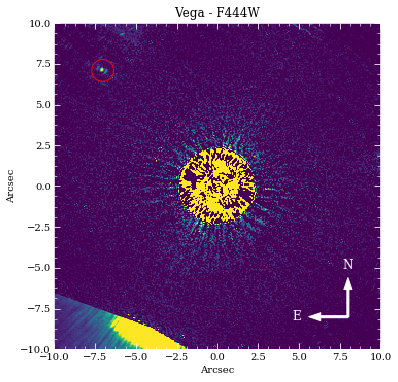

In [169]:
fig, ax = plt.subplots(1,1)

ys, xs = im_final_rot_sub.shape
extent = np.array([-xs/2,xs/2,-ys/2,ys/2])*obs.pix_scale

ax.imshow(im_final_rot_sub, vmin=0, vmax=1, extent=extent)
xylim = 10
ax.set_xlim([-xylim,xylim])
ax.set_ylim([-xylim,xylim])
ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')
ax.set_title('{} - {}'.format(obs.sp_sci.name,obs.filter))

ax.tick_params(axis='both', color='white', which='both')
for k in ax.spines.keys():
    ax.spines[k].set_color('white')

# Location of planet
loc = (np.array(obs.planets[0]['xyoff_pix'])+0.5) * obs.pix_scale
circle = matplotlib.patches.Circle(loc, radius=xylim/15., lw=1, edgecolor='red', facecolor='none')
ax.add_artist(circle);

nrc_utils.plotAxes(ax, label1='E', label2='N')